In [1]:
import torch
from torch.utils.data import Dataset

from transformers import VisionEncoderDecoderModel, TrOCRProcessor
from transformers import AutoTokenizer, VisionEncoderDecoderModel
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import default_data_collator

from datasets import load_dataset, load_metric

from torchvision.transforms.functional import to_pil_image

torch.cuda.empty_cache()

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
torch.cuda.current_device()

0

# Dataset

In [4]:
class KhattDataset(Dataset):
    def __init__(self, dataset, processor, max_target_length=128):
        self.dataset = dataset
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # extract the text field
        text = self.dataset['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = self.dataset['image'][idx].convert("RGB")

        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [5]:
train_dataset = load_dataset("Fakhraddin/khatt", split="train")
test_dataset = load_dataset("Fakhraddin/khatt", split="validation")

Found cached dataset parquet (/home/infres/abounhar/.cache/huggingface/datasets/Fakhraddin___parquet/Fakhraddin--khatt-c71484a8da368e20/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Found cached dataset parquet (/home/infres/abounhar/.cache/huggingface/datasets/Fakhraddin___parquet/Fakhraddin--khatt-c71484a8da368e20/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


In [6]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [7]:
train_dataset = KhattDataset(dataset=train_dataset, processor=processor)
test_dataset = KhattDataset(dataset=test_dataset, processor=processor)

In [8]:
print("Number of training examples:", len(train_dataset))
print("Number of testing examples:", len(test_dataset))

Number of training examples: 1400
Number of testing examples: 233


# Model config and training

In [9]:
def compute_metrics(pred):
    cer_metric = load_metric("cer")
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [10]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-384", "aubmindlab/bert-base-arabertv02"
)
# set decoder config to causal lm
model.config.decoder.is_decoder = True
model.config.decoder.add_cross_attention = True

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertLMHeadModel were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['bert.encoder.layer.10.crossattention.self.value.weight', 'bert.encoder.layer.11.crossattention.output.dense.weight', 'bert.encoder.layer.7.crossattention.self.key.weight', 'bert.encoder.layer.8.crossattention.output.dense.bias', 'bert.encoder.layer.5.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.7.crossattention.self.value.bias', 'bert.encoder.layer.7.crossattention.self.value.weight', 'bert.encoder.layer.11.crossattention.self.key.weight', 'bert.encoder.layer.11.crossattention.output.dense.bias', 'bert.encoder.layer.6.crossattention.self.key.w

In [11]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 4
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 1
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [12]:
training_args = Seq2SeqTrainingArguments(
    num_train_epochs=3,
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    fp16=True,
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=10,
    group_by_length =False,
)

In [16]:
processor.feature_extractor

/home/infres/abounhar/moroccoai_project/venv/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:135: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

In [17]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=default_data_collator,
)

In [ ]:
trainer.train()

# Testing

In [19]:
output = trainer.predict(test_dataset)

/home/infres/abounhar/moroccoai_project/venv/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


/tmp/ipykernel_2681699/748468130.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [22]:
test_index = 0
image_tensor=test_dataset[test_index]["pixel_values"]
pil_image = to_pil_image(image_tensor)

In [23]:
output.label_ids[test_index]

array([    0, 33866, 26068,  9264, 39004, 36963,   862, 29438, 31746,
       38605, 25790, 12410, 29434, 38419, 36963, 27819, 21593, 20024,
       21593, 18400, 38419, 25790,  9253, 34955, 20024, 38605, 25790,
        2469, 33070, 39004, 29438, 25790, 18400, 33866, 26174, 30992,
       29438, 26068,  3602, 36963,   862, 33070, 29438, 36963, 27969,
       21593, 18537, 39942, 29434, 42620, 31746, 41519, 21593,  8906,
       26068, 10172,    22, 43321, 39942, 33070, 39004, 29438, 31746,
       26174,   113, 41519, 21593,  3070, 26174, 29434, 39942, 29438,
        1437, 30992, 39942, 29438,     2,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1]

In [24]:
prediction_text = processor.batch_decode(output.label_ids, skip_special_tokens=True)

In [25]:
t_dataset = load_dataset("Fakhraddin/khatt", split="validation")
t_dataset[test_index]

Found cached dataset parquet (/home/infres/abounhar/.cache/huggingface/datasets/Fakhraddin___parquet/Fakhraddin--khatt-c71484a8da368e20/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


{'image': <PIL.TiffImagePlugin.TiffImageFile image mode=L size=2363x112>,
 'text': 'وقد كانت حرة نشطة عاشت أمدا طويلاّ كما يظهر من وصف "الهمداني" وغيرها لها'}

In [26]:
prediction_text[test_index]

'وقد كانت حرة نشطة عاشت أمدا طويلاّ كما يظهر من وصف "الهمداني" وغيرها لها'

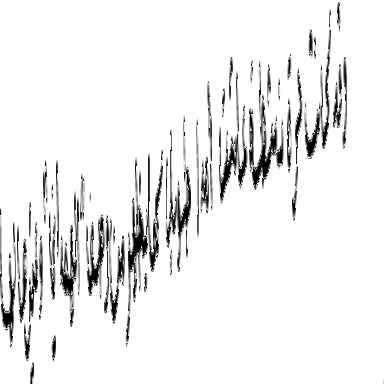

In [27]:
pil_image

In [21]:
torch.save(model,'ocr_ar.pth')

# Pushing the model to Huggingface hub

In [13]:
# Replace "path/to/your/weights.pth" with the actual path to your .pth file
weights_path = "./arabic_ocr/checkpoint-1400/pytorch_model.bin"

In [14]:
# Load the state dict from the .pth file
state_dict = torch.load(weights_path)

In [15]:
# Update the model's state dict with the loaded weights
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
model.push_to_hub("eDaraty/edaraty_neural_net")

In [28]:
processor.tokenizer

RobertaTokenizerFast(name_or_path='microsoft/trocr-base-handwritten', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)}, clean_up_tokenization_spaces=True)

In [29]:
processor.tokenizer.save_pretrained("./arabic_ocr/checkpoint-1400/tokenizer/")

('./arabic_ocr/checkpoint-1400/tokenizer/tokenizer_config.json',
 './arabic_ocr/checkpoint-1400/tokenizer/special_tokens_map.json',
 './arabic_ocr/checkpoint-1400/tokenizer/vocab.json',
 './arabic_ocr/checkpoint-1400/tokenizer/merges.txt',
 './arabic_ocr/checkpoint-1400/tokenizer/added_tokens.json',
 './arabic_ocr/checkpoint-1400/tokenizer/tokenizer.json')

# Testing our model from Huggingface Hub

In [30]:
tokenizer = AutoTokenizer.from_pretrained("eDaraty/edaraty_neural_net")
model_2 = VisionEncoderDecoderModel.from_pretrained("eDaraty/edaraty_neural_net")
processor = TrOCRProcessor.from_pretrained("eDaraty/edaraty_neural_net") 

In [31]:
# set special tokens used for creating the decoder_input_ids from the labels
model_2.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model_2.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model_2.config.vocab_size = model_2.config.decoder.vocab_size

# set beam search parameters
model_2.config.eos_token_id = processor.tokenizer.sep_token_id
model_2.config.max_length = 4
model_2.config.early_stopping = True
model_2.config.no_repeat_ngram_size = 1
model_2.config.length_penalty = 2.0
model_2.config.num_beams = 4

In [32]:
test_index=0
test_dataset[test_index]

{'pixel_values': tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8275],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.7804],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.7804]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8275],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.7804],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.7804]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.000

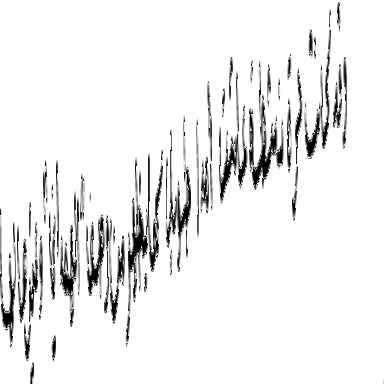

In [33]:
image_tensor=test_dataset[test_index]["pixel_values"]
pil_image = to_pil_image(image_tensor)
pil_image

In [ ]:
pixel_values = processor(pil_image, return_tensors="pt").pixel_values
generated_ids = model_2.generate(pixel_values, max_length=128, do_sample=False)
generated_text = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

print(generated_text)

In [ ]:
t_dataset = load_dataset("Fakhraddin/khatt", split="validation")
t_dataset[test_index]